In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

from neo import io
import pandas as pd
from hmmlearn import hmm

# Load data

In [2]:
r = io.IgorIO(filename='upShots_3623.ibw')
data_an_up = r.read_analogsignal()
data_arr_up = np.array(data_an_up)

r = io.IgorIO(filename='downShots_3624.ibw')
data_an_down = r.read_analogsignal()
data_arr_down = np.array(data_an_down)
data_arr_up.shape

(9992, 5000)

# Setting up functions

In [30]:
def process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind):
    
    # x_0 and x_N should be entered with the same nr of sigfigs, and b_x 
    # should be smaller than the last decimal in x_0 and x_N
    
    len_counts = int((x_N - x_0)/b_x)
    
    counts_up = np.zeros(len_counts)
    counts_down = np.zeros(len_counts)
    processed_up_all = []
    processed_down_all = []
    b_temp_up_all = []
    b_temp_down_all = []
    
    for i in range(data_start_index, data_stop_index):
        data_up_raw = np.array(data_arr_up[:,i])[15:T_ind]
        data_down_raw = np.array(data_arr_down[:,i])[15:T_ind]
        
        temp_up = (data_up_raw - np.ones(len(data_up_raw))*x_0)/(np.ones(len(data_up_raw))*b_x)
        temp_up = (np.rint(temp_up)).astype(int)
        
        temp_down = (data_down_raw - np.ones(len(data_down_raw))*x_0)/(np.ones(len(data_down_raw))*b_x)
        temp_down = (np.rint(temp_down)).astype(int)
        
        processed_up_all.append(temp_up)
        processed_down_all.append(temp_down)
        
        for j in range(len(temp_up)):
            counts_up[temp_up[j]] += 1
            counts_down[temp_down[j]] += 1
        
    return processed_up_all, processed_down_all, counts_up, counts_down

def find_B(up_counts, down_counts, start, stop, T_ind):
            
    b_est_up = up_counts/(np.ones(len(up_counts))*(T_ind-15)*(stop-start))
    b_est_down = down_counts/(np.ones(len(down_counts))*(T_ind-15)*(stop-start))
    
    B = np.array([b_est_up, b_est_down])
    
    return B


def find_B2(up_counts, down_counts, wind_len, T_ind):
            
    b_est_up = up_counts/(np.ones(len(up_counts))*sum(up_counts))
    b_est_down = down_counts/(np.ones(len(down_counts))*sum(down_counts))
    
    B = np.array([b_est_up, b_est_down])
    
    return B

In [4]:
def test(A, B, pi, test_start_index, test_stop_index, test_data_up, test_data_down):
    
    # new model
    model = hmm.CategoricalHMM(n_components=2)
    model.transmat_ = A
    model.emissionprob_ = B
    model.startprob_ = pi

    test_window = (test_stop_index - test_start_index)

    # new
    corru = 0
    wrongu = 0

    corrd = 0
    wrongd = 0

    wrong_ind_up = []
    wrong_ind_down = []
    
    # old
    corru_p = 0
    wrongu_p = 0

    corrd_p = 0
    wrongd_p = 0

    p_wrong_ind_u = []
    p_wrong_ind_d = []

    for i in range(len(test_data_up)):
        res_up_temp = model.predict(np.array(test_data_up[i]).reshape(1,-1))
        res_down_temp = model.predict(np.array(test_data_down[i]).reshape(1,-1))

        # new
        if res_up_temp[-1] == 0:
            corru += 1
        else:
            wrongu += 1
            wrong_ind_up.append(i)

        if res_down_temp[-1] == 1:
            corrd += 1
        else:
            wrongd += 1
            wrong_ind_down.append(i)
        
        # old
        if max(test_data_up[i]) > (47/75)*(x_N-x_0)/b_x:
            res_up_temp = 0
        else:
            res_up_temp = 1

        if max(test_data_down[i]) > (47/75)*(x_N-x_0)/b_x:
            res_down_temp = 0
        else:
            res_down_temp = 1

        if res_up_temp == 0: # if above 470
            corru_p += 1
        else:
            wrongu_p += 1
            p_wrong_ind_u.append(i)

        if res_down_temp == 1: # if not above 470
            corrd_p += 1
        else:
            wrongd_p += 1
            p_wrong_ind_d.append(i)
            
    # new model metrics
    acc_rate_up = corru/(test_window)
    acc_rate_down = corrd/(test_window)
    
    #old mode metrics
    p_acc_rate_up = corru_p/(test_window)
    p_acc_rate_down = corrd_p/(test_window)
    
    return acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down

# Find params

In [45]:
start = 0
stop = 1000

b_x = 0.001
x_0 = -0.20
x_N = 0.55

T_ind = 2500

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

750
750


In [46]:
print('b_x is', b_x)
print('T_ind is', T_ind)
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

b_x is 0.001
T_ind is 2500
Up acc new:  0.988  acc old:  0.99
Down acc new:  0.999  acc old:  0.999


In [48]:
b_x = 0.01
x_0 = -0.20
x_N = 0.55

T_ind = 2500

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T_ind is', T_ind)
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

75
75
b_x is 0.01
T_ind is 2500
Up acc new:  0.944  acc old:  0.989
Down acc new:  0.999  acc old:  0.999


In [50]:
b_x = 0.0005
x_0 = -0.20
x_N = 0.55

T_ind = 2500

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T_ind is', T_ind)
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

1500
1500
b_x is 0.0005
T_ind is 2500
Up acc new:  0.988  acc old:  0.99
Down acc new:  0.999  acc old:  0.999


In [51]:
b_x = 0.005
x_0 = -0.20
x_N = 0.55

T_ind = 2500

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T_ind is', T_ind)
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

150
150
b_x is 0.005
T_ind is 2500
Up acc new:  0.952  acc old:  0.989
Down acc new:  0.999  acc old:  0.999


In [52]:
b_x = 0.00001
x_0 = -0.20
x_N = 0.55

T_ind = 2500

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T_ind is', T_ind)
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

75000
75000
b_x is 1e-05
T_ind is 2500
Up acc new:  0.988  acc old:  0.99
Down acc new:  0.999  acc old:  0.999


In [53]:
b_x = 0.01
x_0 = -0.20
x_N = 0.55

T_ind = 800

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

75
75
b_x is 0.01
T is 314.0
Up acc new:  0.982  acc old:  0.98
Down acc new:  1.0  acc old:  1.0


In [54]:
b_x = 0.005
x_0 = -0.20
x_N = 0.55

T_ind = 800

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

150
150
b_x is 0.005
T is 314.0
Up acc new:  0.982  acc old:  0.98
Down acc new:  1.0  acc old:  1.0


In [55]:
b_x = 0.0001
x_0 = -0.20
x_N = 0.55

T_ind = 800

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

7500
7500
b_x is 0.0001
T is 314.0
Up acc new:  0.983  acc old:  0.981
Down acc new:  1.0  acc old:  1.0


In [56]:
b_x = 0.0005
x_0 = -0.20
x_N = 0.55

T_ind = 800

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

1500
1500
b_x is 0.0005
T is 314.0
Up acc new:  0.983  acc old:  0.981
Down acc new:  1.0  acc old:  1.0


In [57]:
b_x = 0.00001
x_0 = -0.20
x_N = 0.55

T_ind = 800

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

75000
75000
b_x is 1e-05
T is 314.0
Up acc new:  0.983  acc old:  0.981
Down acc new:  1.0  acc old:  1.0


In [59]:
b_x = 0.01
x_0 = -0.20
x_N = 0.55

T_ind = 1700

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

75
75
b_x is 0.01
T is 674.0
Up acc new:  0.945  acc old:  0.989
Down acc new:  0.999  acc old:  0.999


In [60]:
b_x = 0.005
x_0 = -0.20
x_N = 0.55

T_ind = 1700

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

150
150
b_x is 0.005
T is 674.0
Up acc new:  0.952  acc old:  0.989
Down acc new:  0.999  acc old:  0.999


In [61]:
b_x = 0.001
x_0 = -0.20
x_N = 0.55

T_ind = 1700

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

750
750
b_x is 0.001
T is 674.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.999  acc old:  0.999


In [62]:
b_x = 0.0005
x_0 = -0.20
x_N = 0.55

T_ind = 1700

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

1500
1500
b_x is 0.0005
T is 674.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.999  acc old:  0.999


In [63]:
b_x = 0.00001
x_0 = -0.20
x_N = 0.55

T_ind = 1700

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

75000
75000
b_x is 1e-05
T is 674.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.999  acc old:  0.999


In [65]:
b_x = 0.01
x_0 = -0.20
x_N = 0.55

T_ind = 1900

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

75
75
b_x is 0.01
T is 754.0
Up acc new:  0.945  acc old:  0.989
Down acc new:  0.999  acc old:  0.999


In [66]:
b_x = 0.005
x_0 = -0.20
x_N = 0.55

T_ind = 1900

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

150
150
b_x is 0.005
T is 754.0
Up acc new:  0.952  acc old:  0.989
Down acc new:  0.999  acc old:  0.999


In [67]:
b_x = 0.001
x_0 = -0.20
x_N = 0.55

T_ind = 1900

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

750
750
b_x is 0.001
T is 754.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.999  acc old:  0.999


In [68]:
b_x = 0.0005
x_0 = -0.20
x_N = 0.55

T_ind = 1900

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

1500
1500
b_x is 0.0005
T is 754.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.999  acc old:  0.999


In [69]:
b_x = 0.00001
x_0 = -0.20
x_N = 0.55

T_ind = 1900

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

75000
75000
b_x is 1e-05
T is 754.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.999  acc old:  0.999


In [73]:
b_x = 0.01
x_0 = -0.20
x_N = 0.55

T_ind = 1500

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

75
75
b_x is 0.01
T is 594.0
Up acc new:  0.945  acc old:  0.989
Down acc new:  0.999  acc old:  0.999


In [74]:
b_x = 0.005
x_0 = -0.20
x_N = 0.55

T_ind = 1500

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

150
150
b_x is 0.005
T is 594.0
Up acc new:  0.952  acc old:  0.989
Down acc new:  0.999  acc old:  0.999


In [75]:
b_x = 0.001
x_0 = -0.20
x_N = 0.55

T_ind = 1500

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

750
750
b_x is 0.001
T is 594.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.999  acc old:  0.999


In [76]:
b_x = 0.0005
x_0 = -0.20
x_N = 0.55

T_ind = 1500

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

1500
1500
b_x is 0.0005
T is 594.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.999  acc old:  0.999


In [77]:
b_x = 0.00001
x_0 = -0.20
x_N = 0.55

T_ind = 1500

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

75000
75000
b_x is 1e-05
T is 594.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.999  acc old:  0.999


In [93]:
start=0
stop=1000

b_x = 0.00001
x_0 = -0.20
x_N = 0.55

T_ind = 1900

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

75000
75000
b_x is 1e-05
T is 754.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.999  acc old:  0.999


# Train model 

In [94]:
start = 1000
stop = 4000

b_x = 0.001
x_0 = -0.20
x_N = 0.55

T_ind = 1700

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)

B = find_B(counts_up, counts_down, x_0, x_N, b_x, start, stop, T_ind)
A = np.array([[1,0], [0,1]])
pi = np.array([0.5, 0.5])

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T_ind is', T_ind)
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

750
750
b_x is 0.001
T_ind is 1700
Up acc new:  0.8956666666666667  acc old:  0.9906666666666667
Down acc new:  0.9973333333333333  acc old:  0.9963333333333333


# Test model 

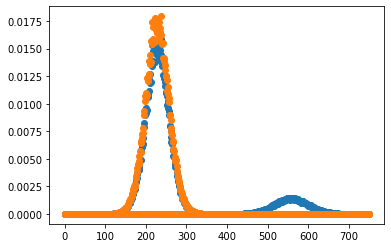

In [95]:
plt.scatter(range(len(B[0])), B[0])
plt.scatter(range(len(B[1])), B[1])

In [97]:
start = 4000
stop = 5000

data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)
acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

750
b_x is 0.001
T is 674.0
Up acc new:  0.907  acc old:  0.987
Down acc new:  0.988  acc old:  0.997


# Train and test model -- rotations

In [25]:
def train_rot(start_ind, wind_len):
    
    if start_ind + wind_len <= 5000:
        start = start_ind 
        stop = start_ind + wind_len
        start1 = 'n'
        stop1 = 'n'
    else:
        start = start_ind 
        stop = 5000
        start1 = 1000
        stop1 = wind_len-(5000-start_ind)

    if start1 == 'n':
        data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)
        
        B = find_B(counts_up, counts_down, start, stop, T_ind)
        A = np.array([[1,0], [0,1]])
        pi = np.array([0.5, 0.5])
        
    else:
        data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)
        data_up1, data_down1, counts_up1, counts_down1 = process_data(start1, stop1, b_x, x_0, x_N, T_ind)
        counts_up_full = np.add(counts_up,counts_up1)
        counts_down_full = np.add(counts_down,counts_down1)
        
        B = find_B2(counts_up_full, counts_down_full, wind_len, T_ind)
        A = np.array([[1,0], [0,1]])
        pi = np.array([0.5, 0.5])     
    
    return A, B, pi

In [26]:
def test_rot(A, B, pi, start_ind, wind_len):

    total = (wind_len)*2
    
    if start_ind + wind_len <= 5000:
        start = start_ind 
        stop = start_ind + wind_len
        start1 = 'n'
        stop1 = 'n'
    else:
        start = start_ind 
        stop = 5000
        start1 = 1000
        stop1 = wind_len-(5000-start_ind)
        
    data_up, data_down, counts_up, counts_down = process_data(start, stop, b_x, x_0, x_N, T_ind)
    acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, start, stop, data_up, data_down)
    
    return acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down

In [12]:
window_size = 3000
test_wind = 1000

train_start_indicies = np.array([1000, 2000, 3000, 4000])
test_start_indicies = np.array([4000, 1000, 2000, 3000])

In [31]:
b_x = 0.001
T_ind = 1700

x_0 = -0.20
x_N = 0.55

for i in range(len(train_start_indicies)):
    
    A, B, pi = train_rot(train_start_indicies[i], window_size)
    
    a, b, c, d = test_rot(A, B, pi, test_start_indicies[i], test_wind)

    print(train_start_indicies[i], 'New: ', round(a, 4), round(b, 4), 'Old: ', round(c, 4), round(d, 4))

1000 New:  0.907 0.988 Old:  0.987 0.997
2000 New:  0.894 0.992 Old:  0.992 0.994
3000 New:  0.912 0.993 Old:  0.99 0.996
4000 New:  0.922 0.986 Old:  0.99 0.999
